In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from datetime import datetime

About this file

These datasets are meteorological data from the HI-SEAS weather station from four months (September through December 2016) between Mission IV and Mission V.

For each dataset, the fields are:

A row number (1-n) useful in sorting this export's results

The UNIX time_t date (seconds since Jan 1, 1970). Useful in sorting this export's results with other export's results
The date in yyyy-mm-dd format
The local time of day in hh:mm:ss 24-hour format
The numeric data, if any (may be an empty string)
The text data, if any (may be an empty string)

The units of each dataset are:

Solar radiation: watts per meter^2

Temperature: degrees Fahrenheit

Humidity: percent

Barometric pressure: Hg

Wind direction: degrees

Wind speed: miles per hour

Sunrise/sunset: Hawaii time

In [ ]:
#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')
raw_data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Solar Radiation Prediction/SolarPrediction.csv")

# What does this data look like?
raw_data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [ ]:
raw_data.tail()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00
32685,1480586402,12/1/2016 12:00:00 AM,00:00:02,1.20,44,30.43,101,83.59,3.37,06:41:00,17:42:00


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Any missing values?

In [ ]:
# to check any missing values in each feature
obs = raw_data.isnull().sum().sort_values(ascending = False)
percent = round(raw_data.isnull().sum().sort_values(ascending = False)/len(raw_data)*100, 2)
pd.concat([obs, percent], axis = 1, keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
TimeSunSet,0,0.0
TimeSunRise,0,0.0
Speed,0,0.0
WindDirection(Degrees),0,0.0
Humidity,0,0.0
Pressure,0,0.0
Temperature,0,0.0
Radiation,0,0.0
Time,0,0.0
Data,0,0.0


# Any duplicated observations?

In [ ]:
raw_data[raw_data.duplicated().values==True]

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet


No duplicated observations exist.

Notice that there is a typo in "Data" title -- it means "Date", I will correct it. I also want to remove "12:00:00 AM" from the values of the observations of this column.

In [ ]:
raw_data_2 = raw_data.copy()

# to remove "12:00:00 AM" 
raw_data_2['Date'] = [pd.to_datetime(d).date().strftime('%Y-%m-%d') for d in raw_data_2['Data']] 
del raw_data_2['Data']

# to rearrange the columns
raw_data_2 = raw_data_2[raw_data_2.columns[[0, 10]+list(range(1,10))]] # 10 is not included as the upper bound

raw_data_2.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,2016-09-29,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,2016-09-29,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,2016-09-29,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,2016-09-29,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,2016-09-29,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [ ]:
raw_data_2.tail()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
32681,1480587604,2016-12-01,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,2016-12-01,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,2016-12-01,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,2016-12-01,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00
32685,1480586402,2016-12-01,00:00:02,1.20,44,30.43,101,83.59,3.37,06:41:00,17:42:00


# Sorting by Date and Time

In [ ]:
data_sorted = raw_data_2.sort_values(by=['Date', 'Time'])
data_sorted.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,2016-09-01,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,2016-09-01,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,2016-09-01,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,2016-09-01,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,2016-09-01,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


In [ ]:
data_sorted.tail()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
24526,1483263302,2016-12-31,23:35:02,1.22,41,30.34,83,238.94,6.75,06:57:00,17:54:00
24525,1483263601,2016-12-31,23:40:01,1.21,41,30.34,82,236.79,5.62,06:57:00,17:54:00
24524,1483263904,2016-12-31,23:45:04,1.21,42,30.34,81,218.28,7.87,06:57:00,17:54:00
24523,1483264203,2016-12-31,23:50:03,1.19,41,30.34,80,215.23,7.87,06:57:00,17:54:00
24522,1483264501,2016-12-31,23:55:01,1.21,41,30.34,81,215.56,9.00,06:57:00,17:54:00


In [ ]:
# to create newTime feature
data_sorted['newTime'] =data_sorted['Date'].map(str) + '-' + data_sorted['Time']
data_sorted.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,newTime
7416,1472724008,2016-09-01,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00,2016-09-01-00:00:08
7415,1472724310,2016-09-01,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00,2016-09-01-00:05:10
7414,1472725206,2016-09-01,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00,2016-09-01-00:20:06
7413,1472725505,2016-09-01,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00,2016-09-01-00:25:05
7412,1472725809,2016-09-01,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00,2016-09-01-00:30:09


In [ ]:
data_groupBy_Date = data_sorted.groupby(['Date']).mean()
data_groupBy_Date.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
Date,,,,,,,
2016-09-01,1.472768e+09,298.451600,54.556000,30.436640,78.968000,112.564000,6.396560
2016-09-02,1.472854e+09,333.471219,56.379928,30.446487,72.501792,115.392079,5.804086
2016-09-03,1.472940e+09,123.974574,55.507092,30.438546,94.599291,192.678546,4.960248
2016-09-04,1.473027e+09,153.584321,53.589286,30.454107,93.878571,126.336714,5.184571
2016-09-05,1.473113e+09,306.065125,53.199288,30.419680,79.943060,209.169253,5.830676


# Add insolationDuration feature

Notice that TimeSunRise	and TimeSunSet are duplicated for each unique Date, I'll create a new data set that contains insolation duration in minutes for each Date.

In [ ]:
data_for_insolationDuration = raw_data_2.copy()[['Date', 'TimeSunRise',	'TimeSunSet']].drop_duplicates()
data_for_insolationDuration.head()

,Date,TimeSunRise,TimeSunSet
0,2016-09-29,06:13:00,18:13:00
285,2016-09-28,06:13:00,18:14:00
567,2016-09-27,06:13:00,18:15:00
848,2016-09-26,06:12:00,18:15:00
1111,2016-09-25,06:12:00,18:16:00


In [ ]:
data_for_insolationDuration.shape

(118, 3)

In [ ]:
data_for_insolationDuration['insolationDuration'] = (pd.to_datetime(data_for_insolationDuration['TimeSunSet'], format='%H:%M:%S') - 
                                                     pd.to_datetime(data_for_insolationDuration['TimeSunRise'], format='%H:%M:%S')).astype('timedelta64[m]')
data_for_insolationDuration.head()

,Date,TimeSunRise,TimeSunSet,insolationDuration
0,2016-09-29,06:13:00,18:13:00,720.0
285,2016-09-28,06:13:00,18:14:00,721.0
567,2016-09-27,06:13:00,18:15:00,722.0
848,2016-09-26,06:12:00,18:15:00,723.0
1111,2016-09-25,06:12:00,18:16:00,724.0


In [ ]:
data_for_insolationDuration = data_for_insolationDuration.sort_values(by=['Date'])
data_for_insolationDuration.head()

,Date,TimeSunRise,TimeSunSet,insolationDuration
7167,2016-09-01,06:07:00,18:38:00,751.0
6888,2016-09-02,06:07:00,18:37:00,750.0
6606,2016-09-03,06:08:00,18:36:00,748.0
6326,2016-09-04,06:08:00,18:35:00,747.0
6045,2016-09-05,06:08:00,18:35:00,747.0


# Radiation by Time

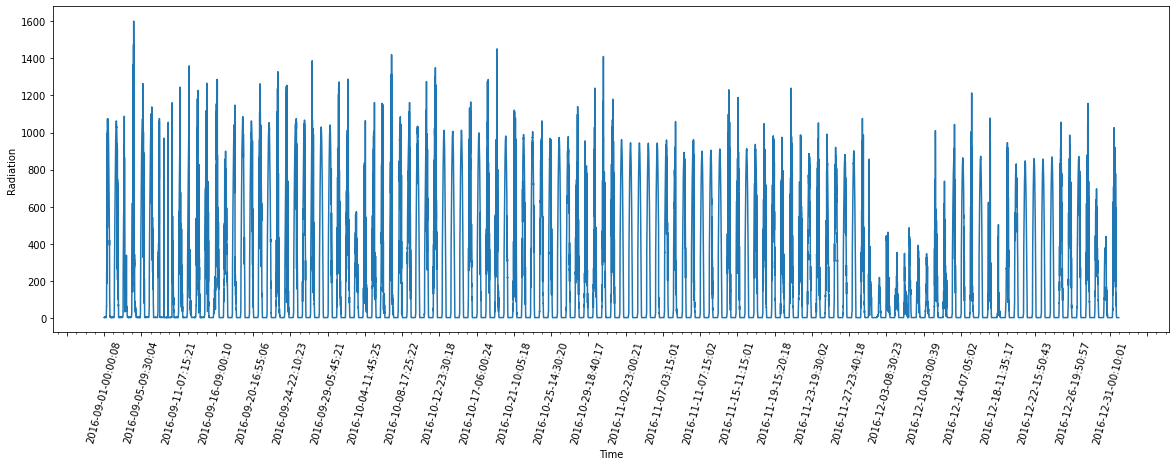

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# Reference: https://matplotlib.org/stable/gallery/ticks_and_spines/major_minor_demo.html
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_sorted['newTime'], data_sorted['Radiation'])

# Make a plot with major ticks that are multiples of 1200 and minor ticks that are multiples of 300.  Label major ticks with '.0f' formatting but don't label minor ticks.  The string is used directly,
# the `StrMethodFormatter` is created automatically.
ax.xaxis.set_major_locator(MultipleLocator(1200))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(300))
plt.xlabel('Time')
plt.ylabel('Radiation')
degree=75
plt.xticks(rotation=degree)
plt.show()

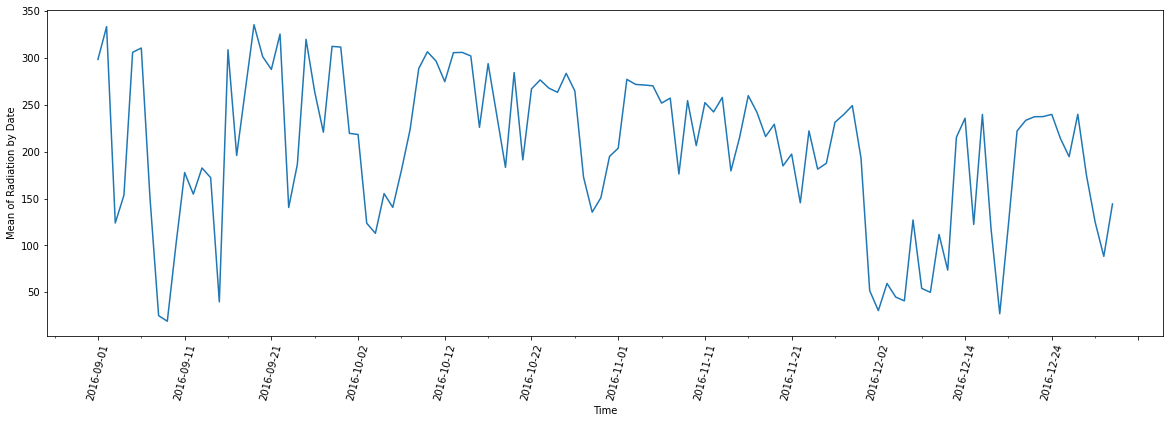

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_groupBy_Date.index, data_groupBy_Date['Radiation'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Time')
plt.ylabel('Mean of Radiation by Date')
degree=75
plt.xticks(rotation=degree)
plt.show()

# Temperature by Time

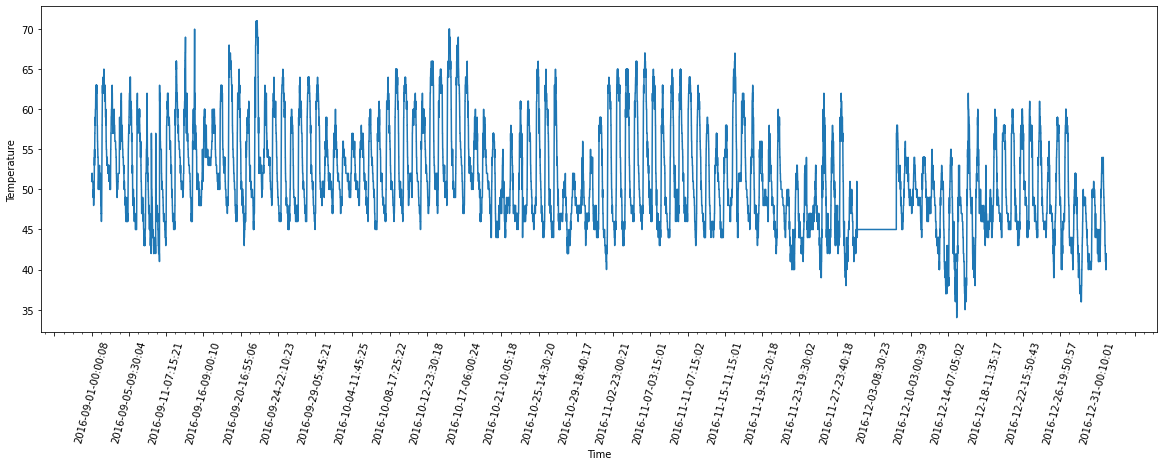

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_sorted['newTime'], data_sorted['Temperature'])
ax.xaxis.set_major_locator(MultipleLocator(1200))
ax.xaxis.set_minor_locator(MultipleLocator(300))
plt.xlabel('Time')
plt.ylabel('Temperature')
degree=75
plt.xticks(rotation=degree)
plt.show()

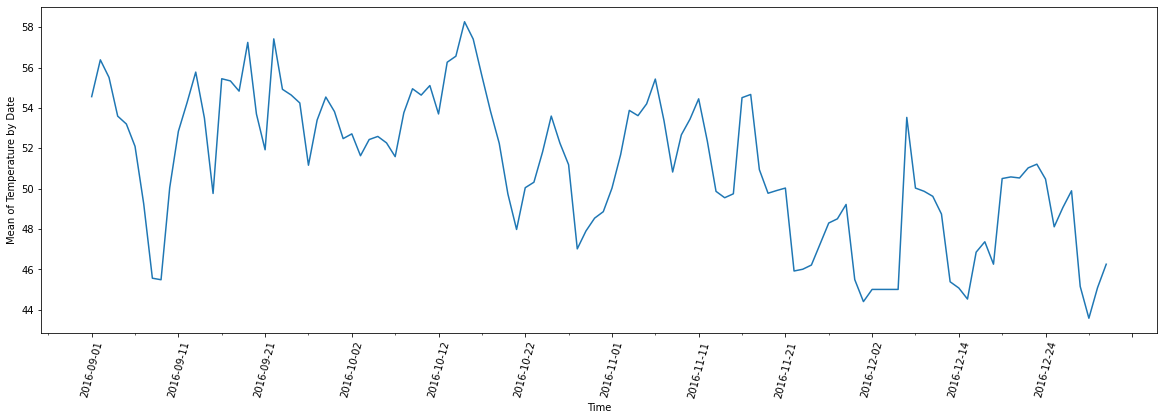

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_groupBy_Date.index, data_groupBy_Date['Temperature'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Time')
plt.ylabel('Mean of Temperature by Date')
degree=75
plt.xticks(rotation=degree)
plt.show()

# Pressure by Time

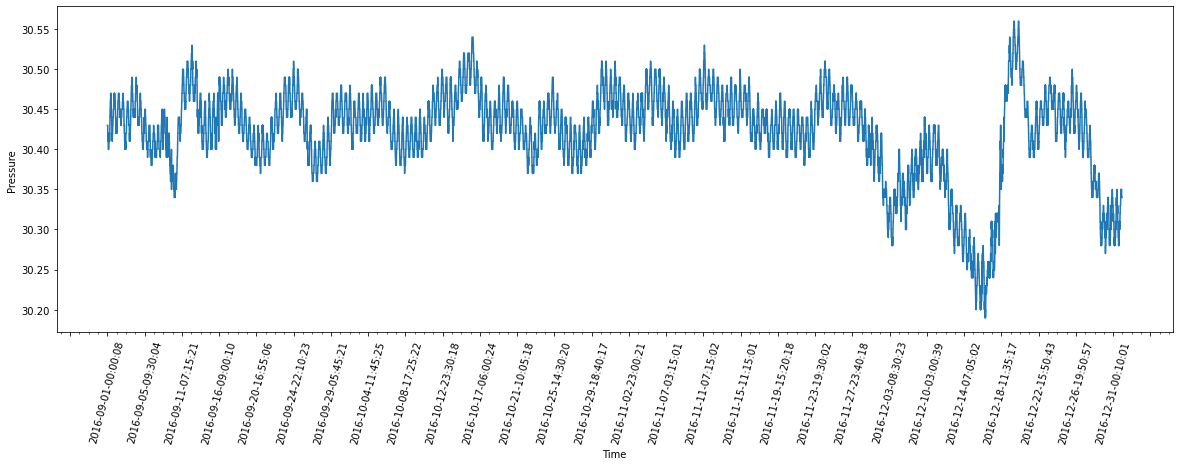

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_sorted['newTime'], data_sorted['Pressure'])
ax.xaxis.set_major_locator(MultipleLocator(1200))
ax.xaxis.set_minor_locator(MultipleLocator(300))
plt.xlabel('Time')
plt.ylabel('Pressure')
degree=75
plt.xticks(rotation=degree)
plt.show()

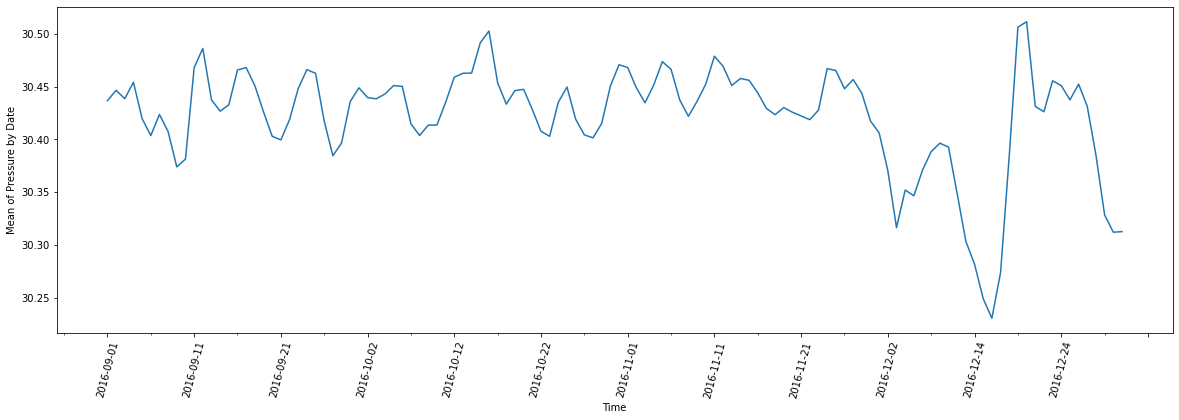

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_groupBy_Date.index, data_groupBy_Date['Pressure'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Time')
plt.ylabel('Mean of Pressure by Date')
degree=75
plt.xticks(rotation=degree)
plt.show()

# Humidity by Time

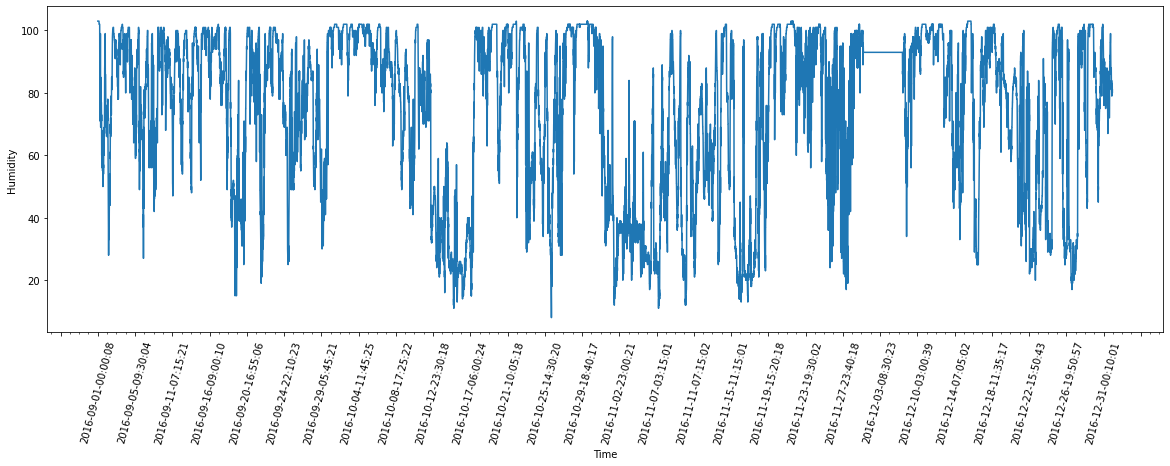

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_sorted['newTime'], data_sorted['Humidity'])
ax.xaxis.set_major_locator(MultipleLocator(1200))
ax.xaxis.set_minor_locator(MultipleLocator(300))
plt.xlabel('Time')
plt.ylabel('Humidity')
degree=75
plt.xticks(rotation=degree)
plt.show()

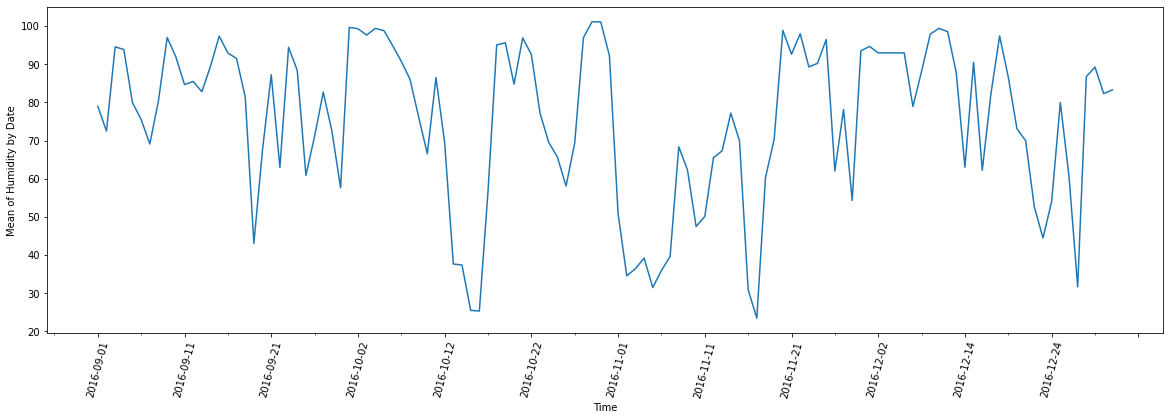

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_groupBy_Date.index, data_groupBy_Date['Humidity'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Time')
plt.ylabel('Mean of Humidity by Date')
degree=75
plt.xticks(rotation=degree)
plt.show()

# 	WindDirection(Degrees) by Time

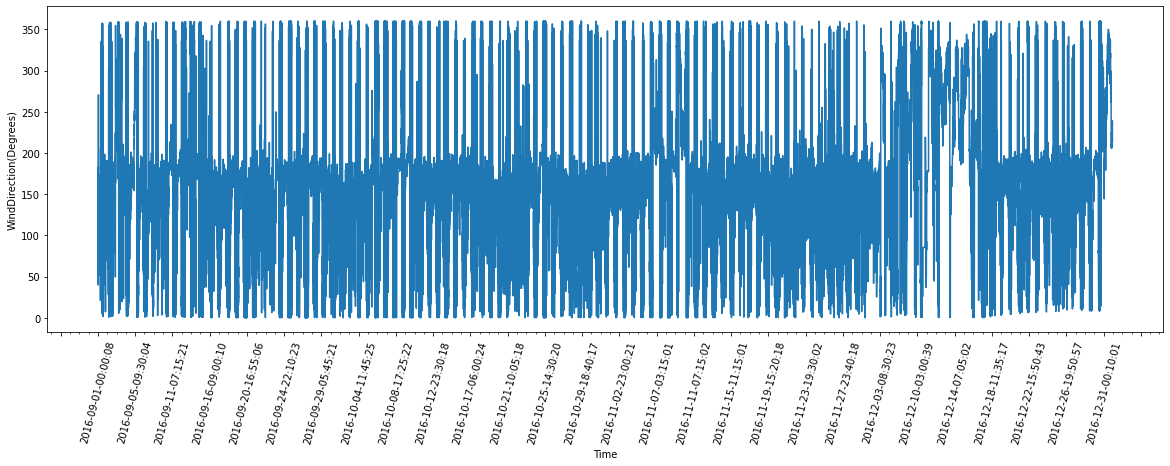

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_sorted['newTime'], data_sorted['WindDirection(Degrees)'])
ax.xaxis.set_major_locator(MultipleLocator(1200))
ax.xaxis.set_minor_locator(MultipleLocator(300))
plt.xlabel('Time')
plt.ylabel('WindDirection(Degrees)')
degree=75
plt.xticks(rotation=degree)
plt.show()

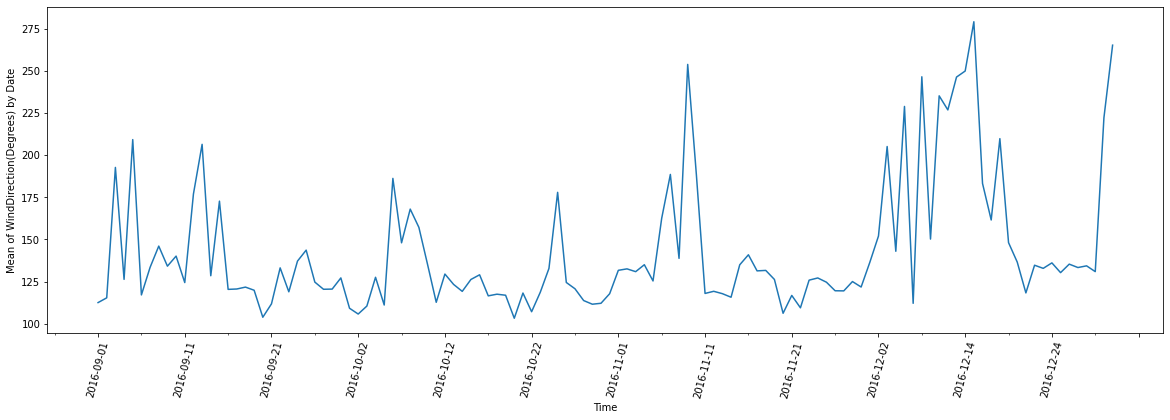

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_groupBy_Date.index, data_groupBy_Date['WindDirection(Degrees)'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Time')
plt.ylabel('Mean of WindDirection(Degrees) by Date')
degree=75
plt.xticks(rotation=degree)
plt.show()

# Speed by Time

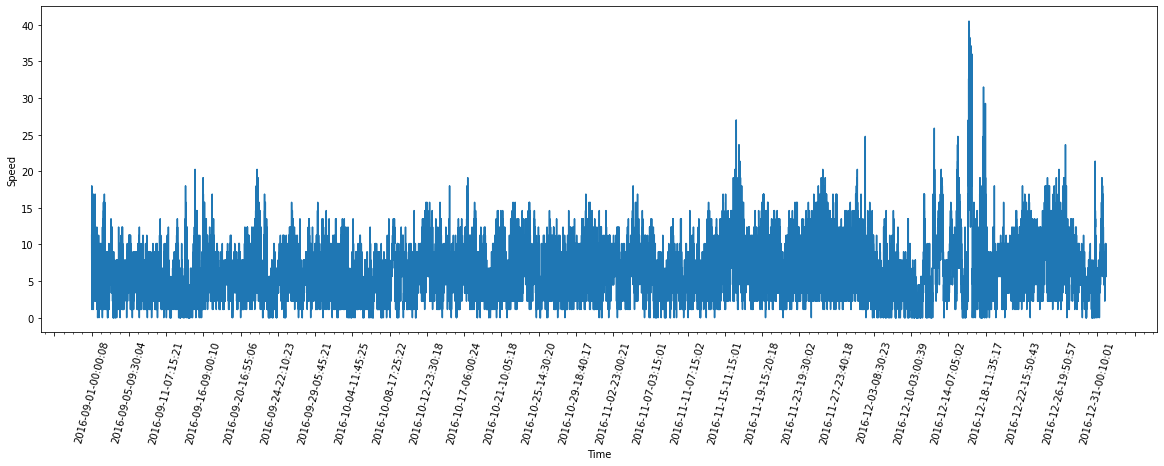

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_sorted['newTime'], data_sorted['Speed'])
ax.xaxis.set_major_locator(MultipleLocator(1200))
ax.xaxis.set_minor_locator(MultipleLocator(300))
plt.xlabel('Time')
plt.ylabel('Speed')
degree=75
plt.xticks(rotation=degree)
plt.show()

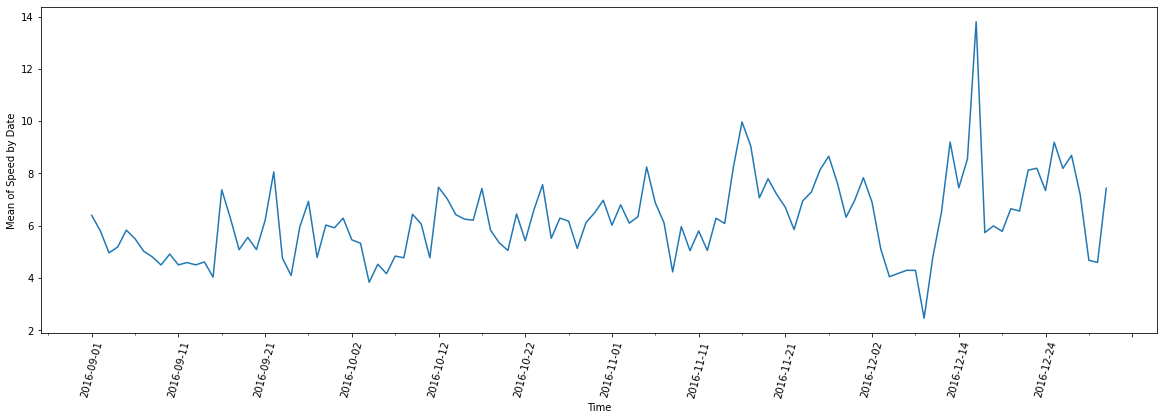

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_groupBy_Date.index, data_groupBy_Date['Speed'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Time')
plt.ylabel('Mean of Speed by Date')
degree=75
plt.xticks(rotation=degree)
plt.show()

# InsolationDuration by Time

In [ ]:
data_for_insolationDuration.head()

,Date,TimeSunRise,TimeSunSet,insolationDuration
7167,2016-09-01,06:07:00,18:38:00,751.0
6888,2016-09-02,06:07:00,18:37:00,750.0
6606,2016-09-03,06:08:00,18:36:00,748.0
6326,2016-09-04,06:08:00,18:35:00,747.0
6045,2016-09-05,06:08:00,18:35:00,747.0


In [ ]:
data_for_insolationDuration.tail()

,Date,TimeSunRise,TimeSunSet,insolationDuration
25670,2016-12-27,06:56:00,17:52:00,656.0
25382,2016-12-28,06:56:00,17:52:00,656.0
25095,2016-12-29,06:56:00,17:53:00,657.0
24810,2016-12-30,06:57:00,17:54:00,657.0
24522,2016-12-31,06:57:00,17:54:00,657.0


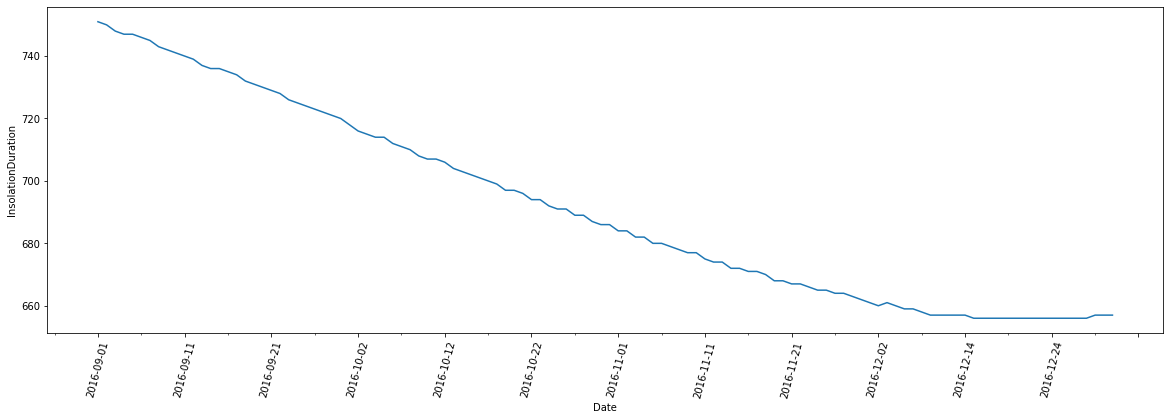

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_for_insolationDuration['Date'], data_for_insolationDuration['insolationDuration'])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.xlabel('Date')
plt.ylabel('InsolationDuration')
degree=75
plt.xticks(rotation=degree)
plt.show()

# How does insolationDuration affect other numeric features?

Recall data_groupBy_Date dataset contains the means of each numeric features, I will combine it with data_for_insolationDuration dataset that contains insolation duration for each date.

In [ ]:
data_groupBy_Date.head(3)

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
Date,,,,,,,
2016-09-01,1.472768e+09,298.451600,54.556000,30.436640,78.968000,112.564000,6.396560
2016-09-02,1.472854e+09,333.471219,56.379928,30.446487,72.501792,115.392079,5.804086
2016-09-03,1.472940e+09,123.974574,55.507092,30.438546,94.599291,192.678546,4.960248


In [ ]:
data_for_insolationDuration.head(3)

,Date,TimeSunRise,TimeSunSet,insolationDuration
0,2016-09-29,06:13:00,18:13:00,720.0
285,2016-09-28,06:13:00,18:14:00,721.0
567,2016-09-27,06:13:00,18:15:00,722.0


In [ ]:
# to rename the column names
subset1 = data_groupBy_Date.copy()[['Radiation',	'Temperature',	'Pressure', 'Humidity', 'WindDirection(Degrees)',	'Speed']]
subset1.columns = ['Mean of Radiation',	'Mean of Temperature',	'Mean of Pressure', 'Mean of Humidity', 'Mean of WindDirection',	'Mean of Speed']
subset1.head(3)

,Mean of Radiation,Mean of Temperature,Mean of Pressure,Mean of Humidity,Mean of WindDirection,Mean of Speed
Date,,,,,,
2016-09-01,298.451600,54.556000,30.436640,78.968000,112.564000,6.396560
2016-09-02,333.471219,56.379928,30.446487,72.501792,115.392079,5.804086
2016-09-03,123.974574,55.507092,30.438546,94.599291,192.678546,4.960248


In [ ]:
subset1.shape

(118, 6)

In [ ]:
subset2 = data_for_insolationDuration.copy()
subset2 = subset2[['Date', 'insolationDuration']].set_index('Date')
subset2.head(3)

,insolationDuration
Date,
2016-09-29,720.0
2016-09-28,721.0
2016-09-27,722.0


In [ ]:
subset2.shape

(118, 1)

In [ ]:
data_Means = pd.merge(subset1, subset2, how='outer', left_index=True, right_index=True)
data_Means.head(3)

,Mean of Radiation,Mean of Temperature,Mean of Pressure,Mean of Humidity,Mean of WindDirection,Mean of Speed,insolationDuration
Date,,,,,,,
2016-09-01,298.451600,54.556000,30.436640,78.968000,112.564000,6.396560,751.0
2016-09-02,333.471219,56.379928,30.446487,72.501792,115.392079,5.804086,750.0
2016-09-03,123.974574,55.507092,30.438546,94.599291,192.678546,4.960248,748.0


Since insolationDuration is descreasing monotonically by Date, I don't need to use Date in the following plots.

# insolationDuration and Mean of Radiation

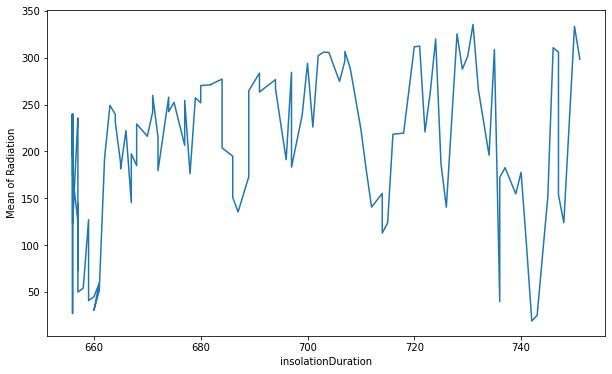

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_Means['insolationDuration'], data_Means['Mean of Radiation'])
plt.xlabel('insolationDuration')
plt.ylabel('Mean of Radiation')
plt.show()

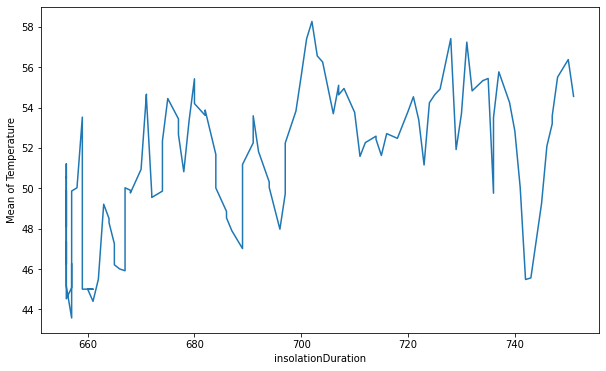

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_Means['insolationDuration'], data_Means['Mean of Temperature'])
plt.xlabel('insolationDuration')
plt.ylabel('Mean of Temperature')
plt.show()

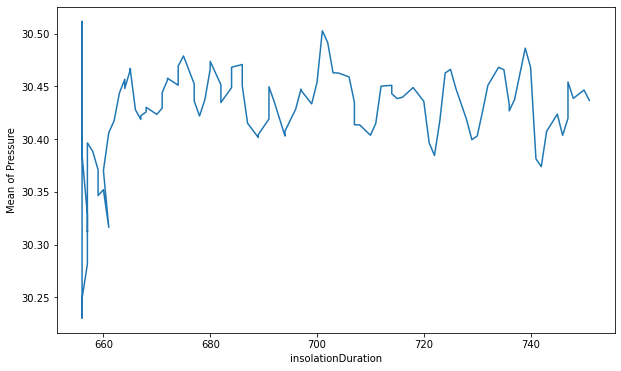

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_Means['insolationDuration'], data_Means['Mean of Pressure'])
plt.xlabel('insolationDuration')
plt.ylabel('Mean of Pressure')
plt.show()

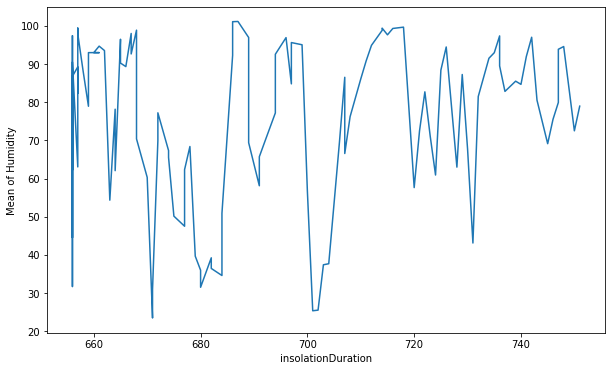

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_Means['insolationDuration'], data_Means['Mean of Humidity'])
plt.xlabel('insolationDuration')
plt.ylabel('Mean of Humidity')
plt.show()

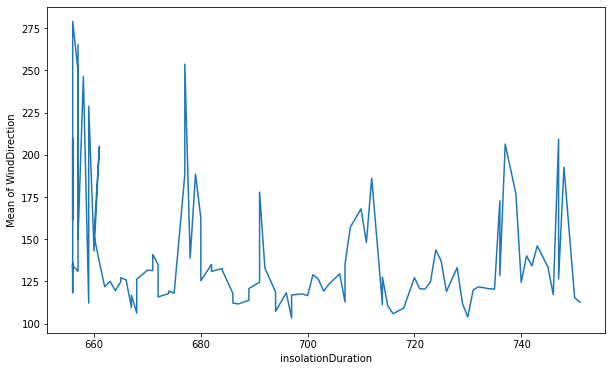

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_Means['insolationDuration'], data_Means['Mean of WindDirection'])
plt.xlabel('insolationDuration')
plt.ylabel('Mean of WindDirection')
plt.show()

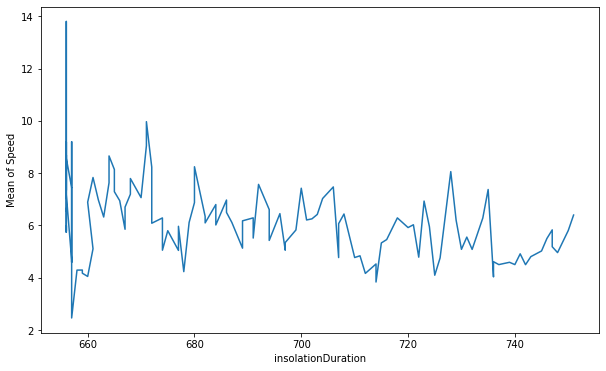

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data_Means['insolationDuration'], data_Means['Mean of Speed'])
plt.xlabel('insolationDuration')
plt.ylabel('Mean of Speed')
plt.show()

No apparent trends are revealed in the above plots. Next, I don't consider insolation duration feature.

# Summary Statistics

In [ ]:
raw_data_2[['Radiation',	'Temperature',	'Pressure', 'Humidity', 'WindDirection(Degrees)',	'Speed']].describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


The above table shows outliers may exist in some features. I will take a look at their histograms and boxplots.

# Histograms and Boxplots

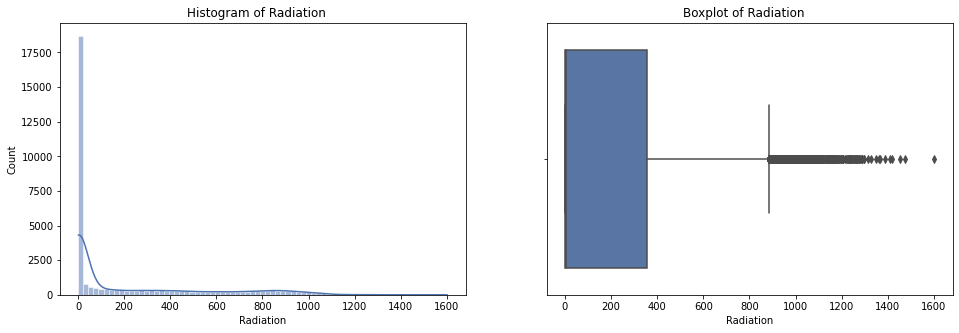

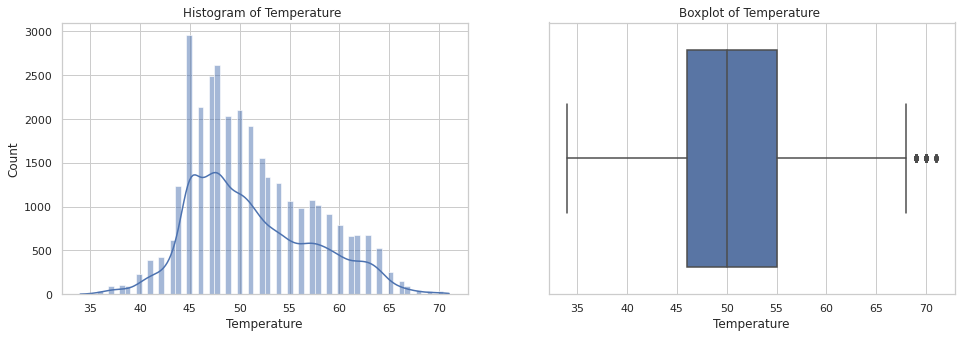

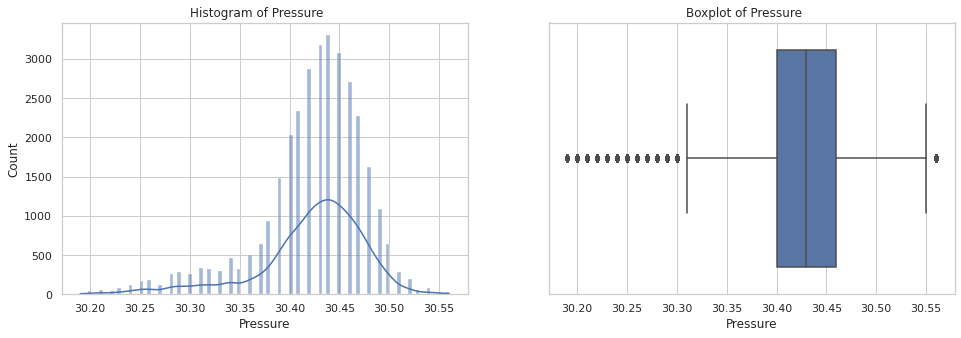

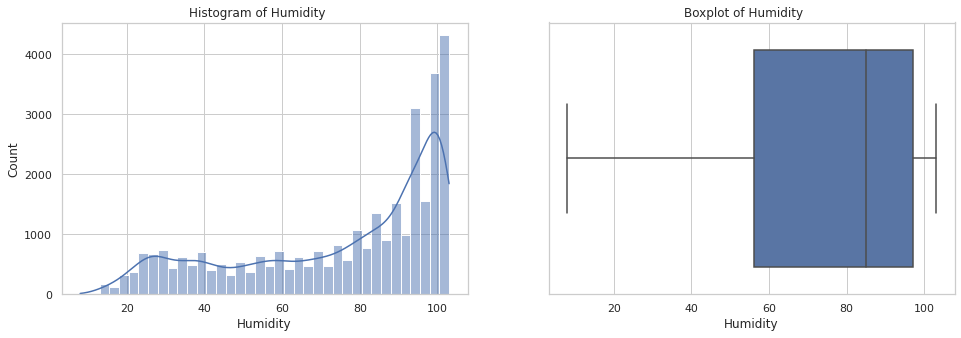

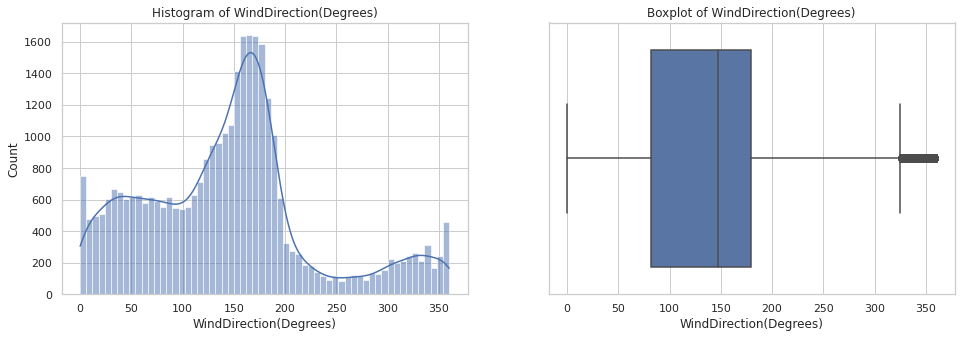

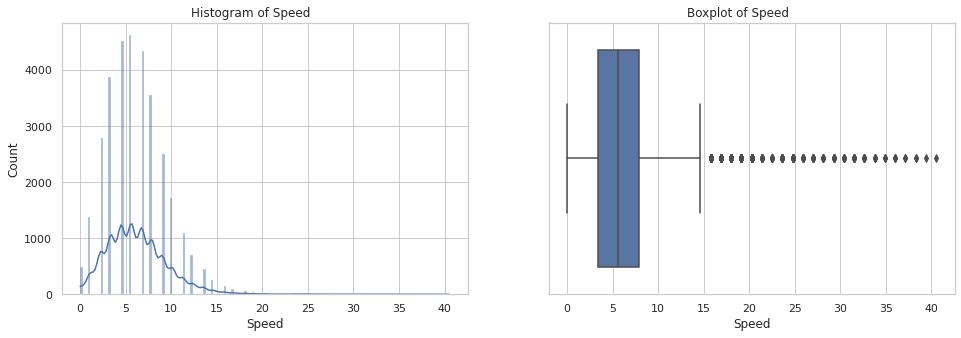

In [ ]:
selected_list = ['Radiation',	'Temperature',	'Pressure',	'Humidity',	'WindDirection(Degrees)',	'Speed']

for fea in selected_list:
  fig, axes = plt.subplots(1, 2, figsize=(16, 5))
  sns.set_theme(style="whitegrid")
  sns.histplot(ax=axes[0], data=raw_data_2[fea], kde=True).set_title('Histogram of %-12s' %(fea))
  sns.boxplot(ax=axes[1], x=raw_data_2[fea]).set_title('Boxplot of %-12s' %(fea))

All features show left skewd or right skewd in their histograms; all features except Humidity show univariate outliers exist in their boxplots.

# Scatter Plots

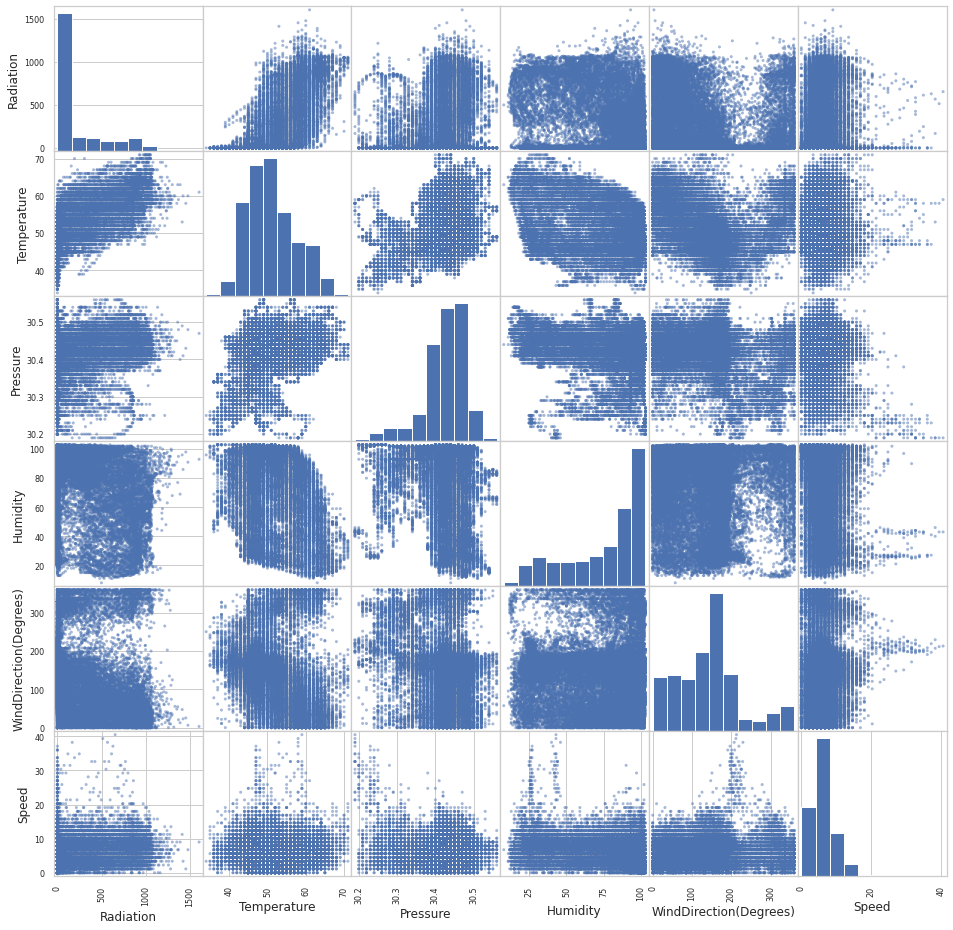

In [ ]:
from pandas.plotting import scatter_matrix

# histograms and scatter plots.
scatter_matrix(raw_data_2[selected_list], figsize=(16, 16))
plt.show()

The scatter plots show cloud type and it means no apperant trends among the features pairwise. Next, I will check their correlation score.

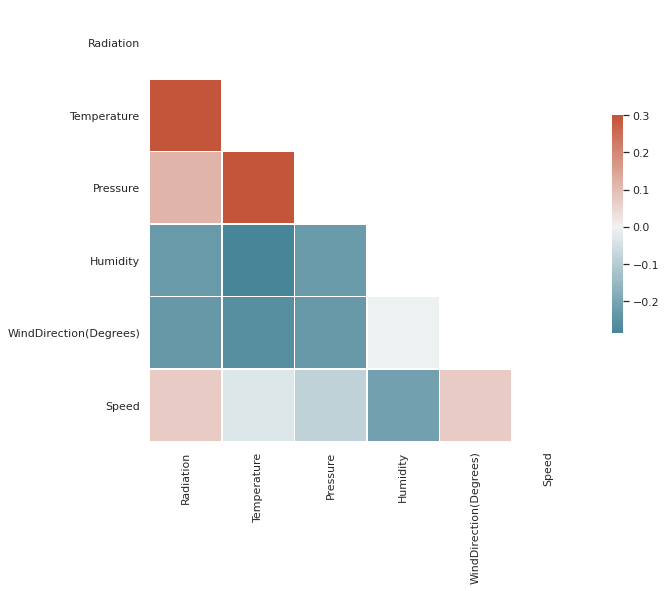

In [ ]:
import seaborn as sns

#sns.set_theme(style="white")

# Compute the correlation matrix
corr = (raw_data_2[selected_list]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The absolute values of the correlation scores are not beyond 0.3.

Now I'll identify multivariate outliers.

# Identify Multivariate Outliers

In [ ]:
raw_data_3 = raw_data_2[selected_list].copy()
raw_data_3.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,1.21,48,30.46,59,177.39,5.62
1,1.21,48,30.46,58,176.78,3.37
2,1.23,48,30.46,57,158.75,3.37
3,1.21,48,30.46,60,137.71,3.37
4,1.17,48,30.46,62,104.95,5.62


I'll calculate Mahalanobis distance for raw_data_3 and identify the outliers.

# Excluding Multivariate Outliers Using Mahalanobis Distance

In [ ]:
# convert DataFrame type to numpy array
raw_data_3 = raw_data_3.to_numpy()
type(raw_data_3)

numpy.ndarray

In [ ]:
len(raw_data_3)

32686

In [ ]:
# Reference: https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance

def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    # one popular way to specify the threshold
    #m = np.mean(MD)
    #t = 3. * m if extreme else 2. * m
    #outliers = []
    #for i in range(len(MD)):
    #    if MD[i] > t:
    #        outliers.append(i)  # index of the outlier
    #return np.array(outliers)

    # or according to the 68–95–99.7 rule
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
outliers_indices = MD_detectOutliers(raw_data_3, verbose=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print("Outliers Indices: {}\n".format(outliers_indices))

Outliers Indices: [  121   136   142 ... 32286 32541 32543]



In [ ]:
len(outliers_indices)

1281

In [ ]:
1281/32686

0.039191090986966895

There are 1281 multivariate outliers, approximately 4% of the data.

In [ ]:
raw_data_4 = raw_data_2.copy()[['UNIXTime',	'Temperature',	'Pressure',	'Humidity',	'WindDirection(Degrees)',	'Speed', 'Radiation']]
raw_data_4.head()

,UNIXTime,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Radiation
0,1475229326,48,30.46,59,177.39,5.62,1.21
1,1475229023,48,30.46,58,176.78,3.37,1.21
2,1475228726,48,30.46,57,158.75,3.37,1.23
3,1475228421,48,30.46,60,137.71,3.37,1.21
4,1475228124,48,30.46,62,104.95,5.62,1.17


In [ ]:
# to exclude the outliers
raw_data_5 = raw_data_4.drop(outliers_indices)
raw_data_5.shape

(31405, 7)

In [ ]:
raw_data_5 = raw_data_5.set_index('UNIXTime')
raw_data_5.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Radiation
UNIXTime,,,,,,
1475229326,48,30.46,59,177.39,5.62,1.21
1475229023,48,30.46,58,176.78,3.37,1.21
1475228726,48,30.46,57,158.75,3.37,1.23
1475228421,48,30.46,60,137.71,3.37,1.21
1475228124,48,30.46,62,104.95,5.62,1.17
